In [ ]:
# Download the dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GeIz3GMuWIRTi_BtW6cYy39O0Mu3ujRF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GeIz3GMuWIRTi_BtW6cYy39O0Mu3ujRF" -O english_hindi.csv && rm -rf /tmp/cookies.txt

In [3]:
# import necessary packages and libraries
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow import keras

from sklearn.model_selection import train_test_split

## Load and preprocess the data

In [4]:
# write a preprocess function
def preprocess(df, source_col, dest_col):
    # get list of punctuation
    punctuations = string.punctuation
    digits = string.digits
    
    remove_digits = str.maketrans('', '', digits)
    # copy the dataset
    dataset = df.copy()
    # convert to lower case
    dataset[source_col] = dataset[source_col].apply(lambda x: x.lower())
    dataset[dest_col] = dataset[dest_col].apply(lambda x: x.lower())
    
    # remove all the punctuations
    dataset[source_col] = dataset[source_col].apply(lambda x: "".join([c for c in x if c not in punctuations]))
    dataset[dest_col] = dataset[dest_col].apply(lambda x: "".join([c for c in x if c not in punctuations]))
    
    # remove all the numbers
    dataset[source_col] = dataset[source_col].apply(lambda x: x.translate(remove_digits))
    dataset[dest_col] = dataset[dest_col].apply(lambda x: x.translate(remove_digits))
    dataset[dest_col] = dataset[dest_col].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))
    
    # Remove extra spaces
    dataset[source_col]=dataset[source_col].apply(lambda x: x.strip())
    dataset[dest_col]=dataset[dest_col].apply(lambda x: x.strip())
    dataset[source_col]=dataset[source_col].apply(lambda x: re.sub(" +", " ", x))
    dataset[dest_col]=dataset[dest_col].apply(lambda x: re.sub(" +", " ", x))
    
    return dataset

In [20]:
# load the dataset
dataset = pd.read_csv("english_hindi.csv")

# remove unnecessary column
dataset = dataset.drop("source", axis=1)

# drop null values
dataset = dataset.dropna(axis=0)

# preprocess the dataset
new_data = preprocess(dataset, "english_sentence", "hindi_sentence")

# add the start and end tokens to the target sentence
new_data['hindi_sentence'] = new_data['hindi_sentence'].apply(lambda x : 'START_ '+ x + ' _END')

# calculate total words in each sentence
new_data["english_nw"] = new_data['english_sentence'].apply(lambda x: len(x.split())) 
new_data["hindi_nw"] = new_data['hindi_sentence'].apply(lambda x: len(x.split())) 

# let's take sentences only upto 20 words max.
max_sent_len = 20
new_data = new_data[new_data.english_nw <= max_sent_len]
new_data = new_data[new_data.hindi_nw <= max_sent_len]

# create tokenizers
eng_tokenizer = Tokenizer(filters='', oov_token='UNK')
hin_tokenizer = Tokenizer(filters='', oov_token='UNK')
# fit tokenizers on respective data
eng_tokenizer.fit_on_texts(new_data["english_sentence"])
hin_tokenizer.fit_on_texts(new_data['hindi_sentence'])

# get source vocab size
eng_vocabsize = len(eng_tokenizer.word_index)
# get target vocab size
hin_vocabsize = len(hin_tokenizer.word_index)

# separate the data into training, testing and validation
source_sent = new_data['english_sentence']
target_sent = new_data["hindi_sentence"]

# split
X_train, X_test, Y_train, Y_test = train_test_split(source_sent, target_sent, test_size=0.2, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape

print("Number of Unique words in english sentences: {}".format(eng_vocabsize))
print("Number of unique words in hindi sentences: {}".format(hin_vocabsize))


Number of Unique words in english sentences: 41593
Number of unique words in hindi sentences: 43172


## Create Datasets

In [6]:
# write a function to create dataset
def create_dataset(source, target, src_tokenizer=eng_tokenizer, tar_tokenizer=hin_tokenizer):
    source_in = src_tokenizer.texts_to_sequences(source)
    target = tar_tokenizer.texts_to_sequences(target)
    
    # convert to ragged tensor
    source_in = tf.ragged.constant(source_in)
    target = tf.ragged.constant(target)
    # create target input and target output
    target_in = target[:, :-1] # without end token
    target_out = target[:, 1:] # without start token
    
    # pad all data to max len
    source_in_padded = source_in.to_tensor(default_value=0)
    target_in_padded = target_in.to_tensor(default_value=0)
    target_out_padded = target_out.to_tensor(default_value=0)
    
    # create a tensorflow datasest
    dataset = tf.data.Dataset.from_tensor_slices(((source_in_padded, target_in_padded), target_out_padded))
    # batch and prefetch dataset
    dataset = dataset.batch(32).prefetch(1)
    return dataset

In [7]:
# create train, valid and test dataset
train_dataset = create_dataset(X_train, Y_train)
valid_dataset = create_dataset(X_valid, Y_valid)
test_dataset = create_dataset(X_test, Y_test)

## Create Attention Layer

In [8]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

## Build Model Architecture

In [9]:
from keras import backend as K 
from tensorflow.keras.layers import Concatenate, TimeDistributed
K.clear_session() 
latent_dim = 128

# Encoder 
encoder_inputs = Input(shape=(max_sent_len,)) 
enc_emb = Embedding(eng_vocabsize+1, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True, dropout=0.2) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True, dropout=0.2) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.2) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(hin_vocabsize+1, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(hin_vocabsize+1, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 128)      5324032     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 20, 128), (N 131584      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

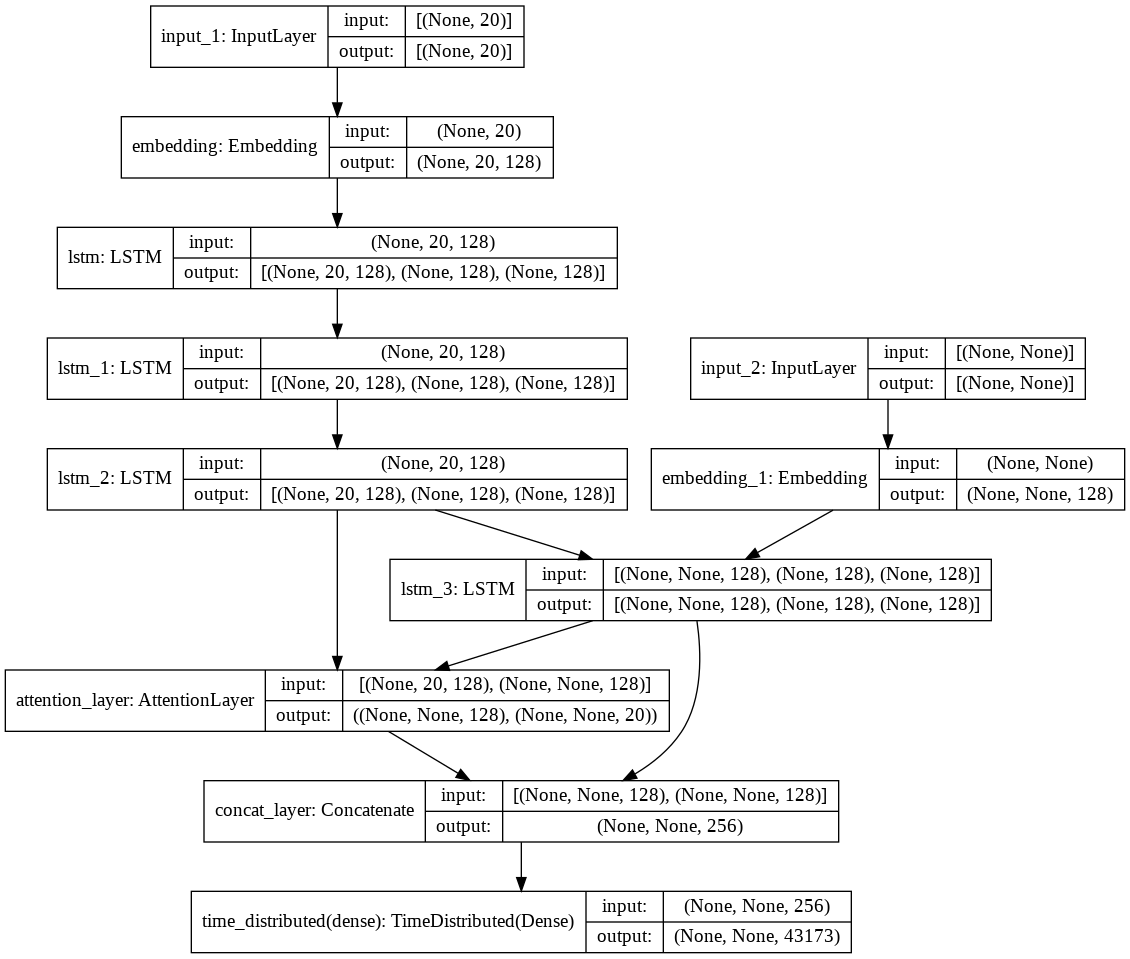

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='drive/MyDrive/hindi_english/images/train_model.png', show_shapes=True)

In [11]:
# create callbacks
checkpoint_path = "/content/drive/MyDrive/hindi_english/models/attention.h5"
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor='val_accuracy',
                                                           mode='max', save_best_only=True)

callbacks = [checkpoint_cb, early_stopping_cb]

In [12]:
# compile and fit the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, 
                    epochs=25, 
#                     callbacks=[lr_schedule],
                    batch_size=32,
                    validation_data = valid_dataset, callbacks=callbacks)

Epoch 1/25
2133/2133 [==============================] - 388s 176ms/step - loss: 3.5153 - accuracy: 0.5406 - val_loss: 3.1639 - val_accuracy: 0.5616
Epoch 2/25
2133/2133 [==============================] - 376s 176ms/step - loss: 2.9153 - accuracy: 0.5748 - val_loss: 2.9195 - val_accuracy: 0.5807
Epoch 3/25
2133/2133 [==============================] - 361s 169ms/step - loss: 2.5630 - accuracy: 0.5966 - val_loss: 2.7751 - val_accuracy: 0.5925
Epoch 4/25
2133/2133 [==============================] - 367s 172ms/step - loss: 2.2580 - accuracy: 0.6204 - val_loss: 2.6789 - val_accuracy: 0.6046
Epoch 5/25
2133/2133 [==============================] - 362s 170ms/step - loss: 2.0107 - accuracy: 0.6440 - val_loss: 2.6169 - val_accuracy: 0.6146
Epoch 6/25
2133/2133 [==============================] - 361s 169ms/step - loss: 1.8149 - accuracy: 0.6685 - val_loss: 2.5784 - val_accuracy: 0.6214
Epoch 7/25
2133/2133 [==============================] - 360s 169ms/step - loss: 1.6597 - accuracy: 0.6899 - val_

### Plot losses and accuracies

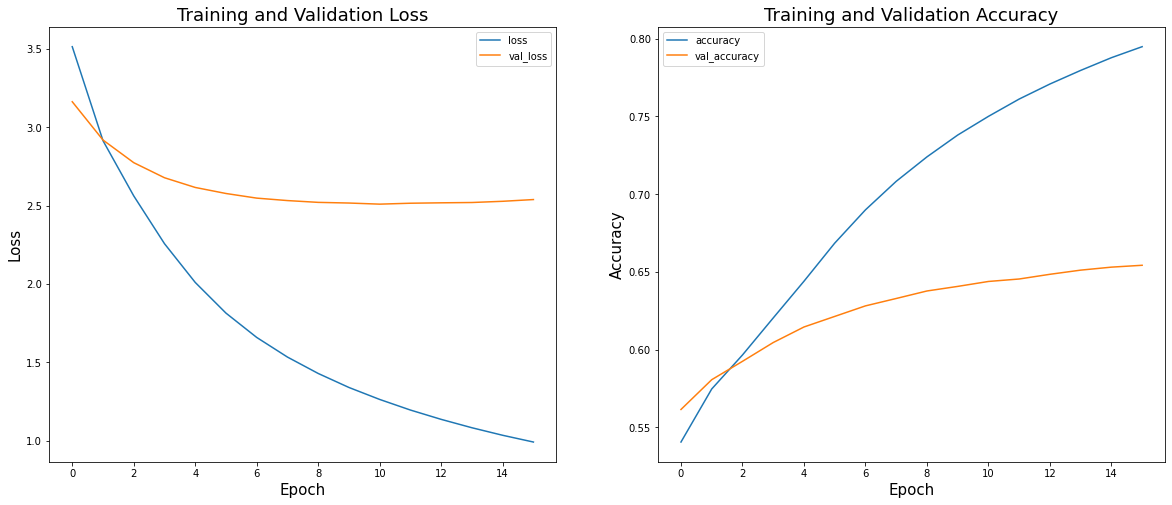

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
pd.DataFrame(history.history)[["loss", "val_loss"]].plot(ax=ax[0])
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot(ax=ax[1])
for i in range(2):
  ax[i].set_xlabel("Epoch",fontsize=15)
  if i == 0:
    ax[i].set_title("Training and Validation Loss", fontsize=18)
    ax[i].set_ylabel("Loss", fontsize=15)
  else:
    ax[i].set_title("Training and Validation Accuracy", fontsize=18)
    ax[i].set_ylabel("Accuracy", fontsize=15)

plt.savefig("drive/MyDrive/hindi_english/images/attention_train.png")
plt.show()

### Evaluate on the test set

In [16]:
loss, acc = model.evaluate(test_dataset, verbose=0)
print("{:25s}".format("Performance on Test Set"))
print("Loss: {}\nAccuracy: {:.2f}%".format(loss, acc*100))

Performance on Test Set  
Loss: 2.5401358604431152
Accuracy: 64.08%
